# Segmentor project

This notebook allows you to create a DeepLabV3 model and train it with a particular dataset on Google Colab Pro. The notebooks is organized as follows:
0. Import the libraries and setting environment
1. Get the dataset
2. Inspect the dataset
3. Set up a pipeline
4. Define loss function
5. Define metrics
6. Define a specific pipeline for DeepLab v3 model
7. Define the DeepLabV3 model
8. Train and save
9. Load a saved model and test it

## 0. Importing libraries and setting environment

In [96]:
import os
import numpy as np
import random
import pandas as pd
import time

# Image manipulation
from PIL import Image
from PIL.PngImagePlugin import PngImageFile

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Tensorflow
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.models import load_model, Model
! pip install tensorflow-addons
import tensorflow_addons as tfa

In [97]:
# Load your Google Colab Pro account
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Change your working directory where you have the project
os.chdir('/content/drive/MyDrive/AI_Projects/Segmentor')

In [99]:
# Fixing the random seed

def fix_random_seed(seed: int):
    """ 
    Sets the seed across all the libraries that use a random generator to have reproducible results

    Arguments:
    - seed (int)

    Returns:
    - None    
    """

    try:
        np.random.seed(seed)
        print(f"Successfully setted the random seed as {seed} for numpy")
    except:
        print("Error when setting seed for numpy")
    try:
        tf.random.set_seed(seed)
        print(f"Successfully setted the random seed as {seed} for tensorflow")
    except:
        print("Error when setting seed for tensorflow")
    try:
        random.seed(seed)
        print(f"Successfully setted the random seed as {seed} for random")
    except:
        print("Error when setting seed for random")

# Fixing the random seed
random_seed = 2021
fix_random_seed(random_seed)

Successfully setted the random seed as 2021 for numpy
Successfully setted the random seed as 2021 for tensorflow
Successfully setted the random seed as 2021 for random


In [ ]:
# Configuring GPUs

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass

In [ ]:
# Defining some constants
FOLDER_IMAGES_JPG = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'JPEGImages')
FOLDER_IMAGES_PNG_DEFAULT = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClass')
FOLDER_IMAGES_PNG_AUG = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'SegmentationClassAug')
FOLDER_IMAGES_SETS = os.path.join('data', 'VOCtrainval_11-May-2012', 'VOCdevkit', 'VOC2012', 'ImageSets','Segmentation')
NUMBER_CLASSES_ORIGINAL = 22 # 1 (background) + 20 (objects) + 1 (border) = 22
NUMBER_CLASSES_MODELLING = 21 # 1 (background) + 20 (objects) = 21

# Modelling constants
HEIGHT_AUGMENTATION = 444 # the image is upsampled to this size and then randomly cropped to the size defined by (HEIGHT_INPUT, WIDTH_INPUT)
WIDTH_AUGMENTATION = 444
HEIGHT_INPUT = 384
WIDTH_INPUT = 384

## 1. Getting the dataset

* Get the Pascal VOC 2012 dataset from the webpage
Link: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

* The augmented dataset for semantic segmentation can be downloaded here:
Link: http://home.bharathh.info/pubs/codes/SBD/download.html
Author: Semantic Contours from Inverse Detectors (Hariharan et al., 2011)

* The *trainaug.txt* file can be downloaded from:
Link: https://gist.githubusercontent.com/sun11/2dbda6b31acc7c6292d14a872d0c90b7/raw/5f5a5270089239ef2f6b65b1cc55208355b5acca/trainaug.txt
Webpage: https://www.sun11.me/blog/2018/how-to-use-10582-trainaug-images-on-DeeplabV3-code/

Once downloaded the dataset, your directory should look like this:
("..." means that there are more files in the folder)


* data
    * VOCtrainval_11-May-2012
        * VOCdevkit
            * VOC2012
                * Annotations
                    * 2007_000027.xml
                    * ...
                * ImageSets
                    * Action
                        * jumping_train.txt
                        * ...
                    * Layout
                        * train.txt
                        * trainval.txt
                        * val.txt
                    * Main
                        * aeroplane_train.txt
                        * ...
                    * Segmentation
                        * train.txt
                        * trainaug.txt
                        * trainval.txt
                        * val.txt
                * JPEGImages
                    * 2007_000027.jpg
                    * ...
                * SegmentationClass
                    * 2007_00032.png
                    * ...
                * SegmentationClassAug
                    * 2007_00032.png
                    * ...
                * SegmentationObject
                    * Not relevant for this notebook

## 2. Inspecting the dataset

Each training example has 2 elements
- input: the original image as a .jpg image
- output: the output, also called the "mask" as a .png image

In [ ]:
# Source: https://www.programcreek.com/python/?CodeExample=get+pascal+labels
def get_pascal_labels():
    """
    Load the mapping that associates pascal classes with label colors

    Arguments:
        - None

    Returns:
        - label_rgb (nd.array): numpy array of shape (22,3)
        - label_names (nd.array): numpy array of shape (22,)
    
    np.ndarray with dimensions (21, 3) this include background (0) and 
         border line separating the class (255)
    """
    label_rgb = np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                       [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                       [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                       [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                       [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                       [0, 64, 128],[224, 224, 192]])
    
    label_names = np.asarray([
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv','border'
    ])

    return label_rgb, label_names

# Source: https://github.com/valeoai/ZS3/blob/master/zs3/dataloaders/utils.py
def segmap_to_image(label_mask, n_classes = NUMBER_CLASSES_ORIGINAL):
    """
    Decode segmentation class labels into a color RGB image
    
    Arguments:
        - label_mask (np.ndarray): an (h,w) array of integer values denoting the class label at each spatial location
        - n_classes (int): the number of classes
    
    Returns:
        - rgb (np.ndarray): the resulting RGB array (normalized)
    """
    label_colours, _ = get_pascal_labels()
    
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    
    for i in range(0, n_classes):
        r[label_mask == i] = label_colours[i, 0]
        g[label_mask == i] = label_colours[i, 1]
        b[label_mask == i] = label_colours[i, 2]
    
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    
    return rgb

def compare_prediction_and_truth(image: np.array, mask_truth: np.array, mask_prediction: np.array):
    """
    Takes a model and compares the prediction with the truth, then plots it.
    Plots: Original image, truth mask, prediction mask, overlay and legend
    
    Arguments:
        - image (np.array): Original image (h,w,3)
        - mask_truth (np.array): shape (h,w)
        - mask_prediction (np.array): shape (h,w)

    Returns:
        - None
    """
    
    # Create the masks
    truth_mask_rgb = segmap_to_image(mask_truth.astype(np.uint8))
    predi_mask_rgb = segmap_to_image(mask_prediction.astype(np.uint8))
    plt.figure(figsize=(20, 5))
    
    # Input image
    grid_spec = gridspec.GridSpec(1, 5, width_ratios=[6, 6, 6, 6, 1])
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    # True segmentation
    plt.subplot(grid_spec[1])
    plt.imshow(truth_mask_rgb)
    plt.axis('off')
    plt.title('truth mask')
    
    # Predicted segmentation 
    plt.subplot(grid_spec[2])
    plt.imshow(predi_mask_rgb)
    plt.axis('off')
    plt.title('predicted mask')

    # Overlay
    plt.subplot(grid_spec[3])
    plt.imshow(image)
    plt.imshow(predi_mask_rgb, alpha=0.5)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    # Legend
    label_colours, label_names = get_pascal_labels()
    unique_labels_prediction = np.unique(mask_prediction)
    unique_labels_prediction_corrected = np.where(unique_labels_prediction == 255, 21, unique_labels_prediction) # correct 255 by 21 (border)
    ax = plt.subplot(grid_spec[4])
    lgd = label_colours[unique_labels_prediction_corrected]
    lgd = lgd.astype(np.uint8)
    plt.imshow(lgd[:,np.newaxis,:])
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels_prediction_corrected)), label_names[unique_labels_prediction_corrected])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')    
     
    plt.show()
    #fig = plt.gcf()

original_image has shape (375, 500, 3)
mask has shape (375, 500)
unique values are = [  0   9  12 255]
counts values are = [72224 78930 27632  8714]


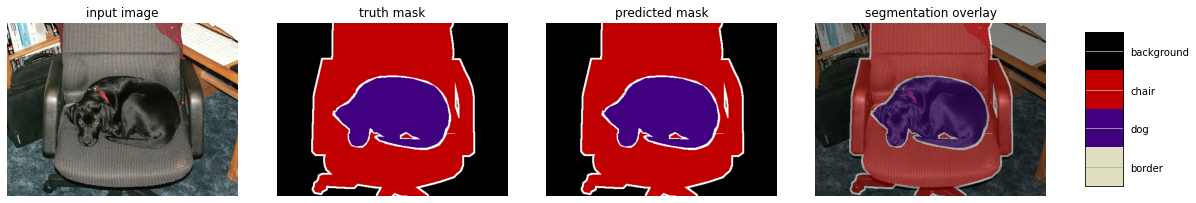

<Figure size 432x288 with 0 Axes>

In [ ]:
# Testing segmap_to_image
file_name = "2007_000063"
jpg_file_path = os.path.join(FOLDER_IMAGES_JPG, file_name + ".jpg")
png_file_path = os.path.join(FOLDER_IMAGES_PNG_AUG, file_name + ".png")

# Original image
original_image = np.array(Image.open(jpg_file_path))
print(f"original_image has shape {original_image.shape}")

# Mask or PNG file
mask = np.array(Image.open(png_file_path))
u1,c1 = np.unique(mask, return_counts=True)
print(f"mask has shape {mask.shape}")
print(f"unique values are = {u1}")
print(f"counts values are = {c1}")

# Plot now, using the original mask as a predicted segmentation (given that we do not have a prediction yet)
compare_prediction_and_truth(original_image, mask, mask)

## 3. Setting a pipeline

We will define a pipeline with tensorflow classes (tf.data.Dataset API).
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

The steps are going to be:
1. Read image from a list
2. Normalize
3. Perform data augmentation

In [ ]:
def get_subset_filenames_generator(subset: str, subset_directory = FOLDER_IMAGES_SETS, jpg_directory = FOLDER_IMAGES_JPG, png_directory = FOLDER_IMAGES_PNG_AUG):
    """ 
    Get the file paths for a given subset (train/trainaug/trainval/val), both the .jpg and the .png file

    Arguments:
        - subset (str): an element from {train/trainaug/trainval/val}
        - subset_directory: 
        - jpg_directory:
        - png_directory:    

    Returns
        - generator of jpg_path, png_path (generators increase performance both in memory usage and speed)
    """
    
    # This is going to be the list of files to get jpg and png path, such as:
    # 2007_000032
    # 2007_000039
    # 2007_000063
    # 2007_000068
    # 2007_000121
    files = []

    if subset in ["train", "trainaug", "trainval", "val"]:
        files = pd.read_csv(os.path.join(subset_directory, subset + ".txt"), 
                            index_col = None,           # the file does not have an index column
                            header = None,              # there is no header
                            squeeze = True              # output will be a Series
                            ).tolist()                  # transform it to list
    else:
        # https://docs.python.org/3/library/exceptions.html
        raise NotImplementedError("Subset " + subset + " is not recognized")
    
    # Now generate two lists one for input images, one for target images
    jpg_filenames = [os.path.join(jpg_directory, f + '.jpg') for f in files]
    png_filenames = [os.path.join(png_directory, f + '.png') for f in files]
    
    # Return a generator that returns an input image and a segmentation image
    for jpg_path, png_path in zip(jpg_filenames, png_filenames):
        yield jpg_path, png_path


# Source: https://newbedev.com/how-to-make-a-generator-callable
# https://tensorexamples.com/2020/07/27/Using-the-tf.data.Dataset.html --> explains this function inside a function
def make_gen_callable(_gen):
    """
    Takes a generator that yields (x,y) and makes it "callable"

    Arguments:
        - _gen: a generator

    Returns
        - gen(): a callable generator
    """
    def gen():
        for x, y in _gen:
            yield x, y
    return gen

In [ ]:
# Testing get_subset_filenames_generator
gen = get_subset_filenames_generator("train")
for i in range(10):
    jpg_path, png_path = next(gen)
    print(jpg_path, png_path)

data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClassAug/2007_000032.png
data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClassAug/2007_000039.png
data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000063.jpg data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClassAug/2007_000063.png
data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000068.jpg data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClassAug/2007_000068.png
data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000121.jpg data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClassAug/2007_000121.png
data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages/2007_000170.jpg data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClassAug/2007_000170.png
data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGI

In [ ]:
def load_image_func(image_path: str):
    """ 
    Load the image given a filename

    Arguments:
        - image_path (str)
    
    Returns:
        - img (np.array)
    """
    img =  np.array(Image.open(image_path))        
    
    return img

def fix_shape(x, y, target_size):
    """ 
    Sets the shape of the input/target tensors

    Arguments:
        - x: input tensor
        - y: target tensor
        - target size: tuple of size
    
    Returns:
        - None
    """
    
    x.set_shape((target_size[0], target_size[1], 3))
    y.set_shape((target_size[0], target_size[1], 1))
    
    return x, y

def randomly_flip_horizontal(x, y, probability = 0.5):
    """ 
    Randomly flip images horizontally

    Arguments:
        - x: input tensor
        - y: target tensor
        - probability: of doing the operation

    Returns:
        - x,y -> tensors after potential flipping
    """
    
    rand = tf.random.uniform([], 0.0, 1.0)

    def flip(x, y):
        return tf.image.flip_left_right(x), tf.image.flip_left_right(y)

    x, y = tf.cond(rand < probability, lambda: flip(x, y), lambda: (x, y))        

    return x, y

def randomly_translate(x, y):
    """
    Randomly translate images

    Arguments:
        - x: input tensor
        - y: target tensor

    Returns:
        - x,y -> tensors after translation
    """
    
    tx, ty = tf.random.uniform([],-50, 50),  tf.random.uniform([], -50, 50)
    x, y = tfa.image.translate(x, [tx, ty]), tfa.image.translate(y, [tx, ty])
    
    return x, y

def resize(x, y, input_size):
    """
    Resize images to a desired size

    Arguments:
        - x: input tensor
        - y: target tensor
        - input_size: size to reshape

    Returns:
        - x,y -> tensors after resizing
    """
    # "bilinear" for smoother interpolation of the x image
    x = tf.image.resize(x, input_size, method='bilinear')

    # "nearest" interpolation so as to make sure the integers value remain
    y = tf.cast(tf.image.resize(tf.transpose(y,[1,2,0]), input_size, method='nearest'),'float32')          
    
    return x, y

def randomly_crop(x, y, resize_to_before_crop, input_size):
    """ 
    Randomly crop images after enlarging them

    Arguments:
        - x: input tensor
        - y: target tensor
        - resize_to_before_crop: shape to resize before cropping
        - input_size: size to crop after resizing
        
    Returns:
        - x,y -> tensors after cropping 
    """
    x = tf.image.resize(x, resize_to_before_crop, method='bilinear')
    y = tf.cast(tf.image.resize(tf.transpose(y,[1,2,0]), resize_to_before_crop, method='nearest'),'float32')
    
    offset_h = tf.random.uniform([], 0, x.shape[0] - input_size[0], dtype='int32')
    offset_w = tf.random.uniform([], 0, x.shape[1] - input_size[1], dtype='int32')
    
    x = tf.image.crop_to_bounding_box(x, offset_h, offset_w, input_size[0], input_size[1])
    y = tf.image.crop_to_bounding_box(y, offset_h, offset_w, input_size[0], input_size[1])
    
    return x, y

def randomly_crop_then_resize(x, y, input_size, resize_to_before_crop, augmentation: bool, probability = 0.5):
    """
    Randomly crops or resizes the images

    Arguments:
        - x: input tensor
        - y: target tensor
        - input_size: input size of the images
        - resize_to_before_crop: shape of resizing before cropping (larger than input)
        - augmentation (bool): True or False
        - probability: of doing the random cropping
        
    Returns:
        - x,y -> tensors after the operations
    """
    
    rand = tf.random.uniform([], 0.0,1.0)
    resizing_is_larger = input_size[0] < resize_to_before_crop[0] and input_size[1] < resize_to_before_crop[1]
    
    # Augmentation must be enabled to do random cropping and resized image must be larger than input image
    if augmentation and resizing_is_larger:
        x, y = tf.cond(
            rand < probability,
            lambda: randomly_crop(x, y, resize_to_before_crop, input_size),
            lambda: resize(x, y, input_size)
            )
    else:
        x, y = resize(x, y, input_size)

    return x, y

In [ ]:
def get_subset_tf_dataset(subset_filename_generator_function, batch_size, epochs, input_size = (HEIGHT_INPUT, WIDTH_INPUT), 
                          resize_to_before_crop = (HEIGHT_AUGMENTATION, WIDTH_AUGMENTATION), augmentation = False, 
                          shuffle = False):
    """
    Creates a tf.data.Dataset object out of a generator with data augmentation if needed

    Arguments:
        - subset_filename_generator_function: callable generator function that provides a list of (jpg_path, png_path)
        - batch_size:
        - epochs:
        - input_size: input shape to work with given by the model       
        - resize_to_before_crop: self-explainable
        - augmentation: True / False
        - shuffle: True / False
        
    Returns:
        - image_ds: tf.data.Dataset object
    """

    # Safety check to make sure that resize_to_before_crop is defined whenever user wants to augment data
    if augmentation and not resize_to_before_crop:
        raise RuntimeError("You must define resize_to_before_crop when augmentation is enabled.")
        
    # Return a list of filenames
    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator
    filename_ds = tf.data.Dataset.from_generator(subset_filename_generator_function, output_types=(tf.string, tf.string))

    # Load the images from the filenames returned by the above step
    # Cache them to prefetch and gain time: https://www.tensorflow.org/guide/data_performance
    # Use of the .map() function https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
    image_ds = filename_ds.map(lambda x,y: (
        tf.image.decode_jpeg(tf.io.read_file(x)),               # here we load the jpg
        tf.numpy_function(load_image_func, [y], [tf.uint8])     # here we load the png
    )).cache()

    # Normalization (only on the x, the mask stays untouched)        
    image_ds = image_ds.map(lambda x, y: (tf.cast(x, 'float32')/255.0, y))
    
    # Resize the images to the input shape   
    image_ds = image_ds.map(lambda x,y: randomly_crop_then_resize(x, y, input_size, resize_to_before_crop, augmentation))
    image_ds = image_ds.map(lambda x,y: fix_shape(x,y, target_size=input_size))
    
    # If augmentations are requested 
    if augmentation:    
        # Randomly flip horizontally to both of them
        image_ds = image_ds.map(lambda x, y: randomly_flip_horizontal(x, y))
        # Randomly adjust color (mask stays the same)
        image_ds = image_ds.map(lambda x, y: (tf.image.random_hue(x, 0.1), y))
        # Randomly adjust brightness (mask stays the same)
        image_ds = image_ds.map(lambda x, y: (tf.image.random_brightness(x, 0.1), y))
        # Randomly adjust contrast (mask stays the same)
        image_ds = image_ds.map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1.2), y))
    
    # Shuffle the data
    if shuffle:
        image_ds = image_ds.shuffle(buffer_size = batch_size*5)
    
    # Batch the data and repeat it for the desired number of epochs
    image_ds = image_ds.batch(batch_size).repeat(epochs)
    
    # Using prefetch for more optimization
    image_ds = image_ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Remove any dimensions of size 1 from the target and return a tensor
    image_ds = image_ds.map(lambda x, y: (x, tf.squeeze(y)))
    
    return image_ds

In [ ]:
# Test get_subset_tf_dataset
generator_training = make_gen_callable(get_subset_filenames_generator("train"))
tr_image_ds = get_subset_tf_dataset(generator_training, batch_size = 1, epochs = 1, augmentation = True)
print(tf.data.DatasetSpec.from_value(tr_image_ds))

# Iterate 2 elements of each dataset
for i, j in tr_image_ds.take(10):
    print(f"i shape is {i.shape}")
    print(f"j shape is {j.shape}")

    x = i[0].numpy()
    ux = np.unique(x)
    print(f"x type is {type(x)} and has shape {x.shape}")
    print(f"unique values on x are {ux}")
    print()
    y = j.numpy().astype(int)
    uy = np.unique(y)
    print(f"unique values on y are {uy}")
    print(f"y type is {type(y)} and has shape {y.shape}")

    compare_prediction_and_truth(x, y, y)

Output hidden; open in https://colab.research.google.com to view.

## 4. Define loss function

The model is going to use dice loss + cross entropy loss, so now we define those elements:
 * dice loss
 * cross entropy loss
 * dice loss + cross entropy loss

In [ ]:
# Ignore the 255 (boundary / unknown object class)
num_classes = NUMBER_CLASSES_MODELLING # This is 21 

def get_label_weights(y_true, y_pred):
    """ 
    Get label weights, so as to mitigate the class imbalance of the images
    
    Arguments:
        - y_true: target value, shape (batch = b, height, width)
        - y_pred: predicted value

    Returns:
        - y_weights: weigths
    """
    
    # Gets the total pixels per class in y_true
    # First one hot encode the vector to shape (b, h, w, k = classes)
    weights = tf.reduce_sum(tf.one_hot(y_true, num_classes), axis=[1,2]) # [b, k]
    
    # Get pixel sum for each image -> [b, 1]
    tot = tf.reduce_sum(weights, axis=-1, keepdims=True) 
    
    # More frequent pixels get smaller weight and rare ones get larger weights
    weights = (tot - weights) / tot # [b, k]
    
    # Turn y_true to a [b, -1] sized output
    y_true = tf.reshape(y_true, [-1, y_pred.shape[1]*y_pred.shape[2]]) #[b, -1]
        
    # For each annotated pixel, get the associated weight from the weight vector
    y_weights = tf.gather(weights, y_true, batch_dims=1)     
    y_weights = tf.reshape(y_weights, [-1])
    
    # return weights
    return y_weights


def dice_loss_from_logits(num_classes = NUMBER_CLASSES_MODELLING):
    """ 
    Defining the dice loss 1 - [(2* i + 1)/(u + i)]. The function is defined as a nested one because we need to include 
    an extra parameter to the loss_fn "num_classes"-

    Arguments:
        - num_classes: 
    
    Returns:
        - a function that computes the dice loss
    """    
    
    def loss_fn(y_true, y_pred):
        """
        Defines the dice loss
        """
        
        smooth = 1. # for avoiding division by zero
        
        # Convert y_true to int and set shape
        y_true = tf.cast(y_true, 'int32')
        y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])

        # Get pixel weights
        y_weights = tf.reshape(get_label_weights(y_true, y_pred), [-1, 1])

        # Apply softmax to logits      
        y_pred = tf.nn.softmax(y_pred)

        # Unwrap both y_true and y_pred on width and height dimensions
        # y_true -> [b*h*w]
        # y_pred -> [b*h*w, 22]

        y_true_unwrap = tf.reshape(y_true, [-1])
        # Any label having a higher value than the depth we defined, is ignored
        y_true_unwrap = tf.cast(tf.one_hot(tf.cast(y_true_unwrap, 'int32'), num_classes), 'float32')    
        y_pred_unwrap = tf.reshape(y_pred, [-1, num_classes])

        # Intersection is taken by multiplying y_true_unwrap * y_pred_unwrap * weights
        intersection = tf.reduce_sum(y_true_unwrap * y_pred_unwrap * y_weights)
        # Union is the sum of y_true_unwrap and y_pred_unwrap
        union = tf.reduce_sum((y_true_unwrap + y_pred_unwrap) * y_weights)

        # compute the dice coefficient
        score = (2. * intersection + smooth) / ( union + smooth)

        # Compute the loss
        loss = 1 - score

        return loss
    
    return loss_fn
    

def ce_weighted_from_logits(num_classes = NUMBER_CLASSES_MODELLING):
    """
    Creates a mask to filter out irrelevant pixels (class = 255), then unravels the matrix
    so as to work with a vector, and finally computes the cross entropy loss. The function
    is defined as a nested one because we need to include an extra parameter to the loss_fn
    -"num_classes"-.

    Arguments:
        - num_classes: the number of modelling classes,

    Returns:
        - a loss function 
    """

    def loss_fn(y_true, y_pred):
        """ 
        Defining cross entropy weighted loss 
        """

        # We are going to ignore the 255-label class
        valid_mask = tf.cast(tf.reshape((y_true <= num_classes - 1), [-1,1]), 'int32')

        y_true = tf.cast(y_true, 'int32')
        y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])

        y_weights = get_label_weights(y_true, y_pred)
        y_pred_unwrap = tf.reshape(y_pred, [-1, num_classes])            
        y_true_unwrap = tf.reshape(y_true, [-1]) 

        return tf.reduce_mean(
            y_weights * tf.nn.sparse_softmax_cross_entropy_with_logits( # we don't need to use one hot encoding -> memory efficient
                y_true_unwrap * tf.squeeze(valid_mask),                 # computing loss from logits leads to better and more stable gradients
                y_pred_unwrap * tf.cast(valid_mask, 'float32')) 
        )
    
    return loss_fn

def ce_dice_loss_from_logits(num_classes = NUMBER_CLASSES_MODELLING):
    """
    Computes the cross entropy loss plus the dice loss

    Arguments:
        - num_classes: the number of modelling classes

    Returns:
        - a loss function 
    """

    def loss_fn(y_true, y_pred):
        """
        Defines the final loss function
        """
        # Sum of cross entropy and dice losses
        loss = ce_weighted_from_logits(num_classes)(tf.cast(y_true, 'int32'), y_pred) + dice_loss_from_logits(num_classes)(y_true, y_pred)    
            
        return loss
    
    return loss_fn

## 5. Define metrics

Here we will be defining three different metrics
* Mean IoU
* Mean accuracy
* Pixel accuracy

In [ ]:
class MeanIoUMetric(tf.keras.metrics.MeanIoU):

  def __init__(self, num_classes, name='mean_iou', **kwargs):
    super(MeanIoUMetric, self).__init__(num_classes=num_classes, name=name, **kwargs)    

  def update_state(self, y_true, y_pred, sample_weight=None):
    
    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
    y_true = tf.reshape(y_true, [-1])

    y_pred = tf.nn.softmax(y_pred)           
    y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])

    valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])

    # Get pixels corresponding to valid mask
    y_true = tf.boolean_mask(y_true, valid_mask)
    y_pred = tf.boolean_mask(y_pred, valid_mask)
    
    super(MeanIoUMetric, self).update_state(y_true, y_pred)
    

class MeanAccuracyMetric(tf.keras.metrics.Mean):

  def __init__(self, num_classes, name='mean_accuracy', **kwargs):
    super(MeanAccuracyMetric, self).__init__(name=name, **kwargs)    

  def update_state(self, y_true, y_pred, sample_weight=None):
    
    smooth = 1            

    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])

    # Unwrap y_true y_pred
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])

    valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])

    y_true = tf.boolean_mask(y_true, valid_mask)
    y_pred = tf.boolean_mask(y_pred, valid_mask)

    # sum on axis=0 > prediction counts 
    # sum on axis=1 > actual counts
    conf_matrix = tf.cast(tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes), 'float32')
    true_pos = tf.linalg.diag_part(conf_matrix)

    # Add a smooth constant in case denominator is zero
    mean_accuracy = tf.reduce_mean(
        (true_pos + smooth)/(tf.reduce_sum(conf_matrix, axis=1) + smooth)
    )
    
    super(MeanAccuracyMetric, self).update_state(mean_accuracy)
    

class PixelAccuracyMetric(tf.keras.metrics.Accuracy):

  def __init__(self, num_classes, name='pixel_accuracy', **kwargs):
    super(PixelAccuracyMetric, self).__init__(name=name, **kwargs)    

  def update_state(self, y_true, y_pred, sample_weight=None):
    
    y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
    y_true = tf.reshape(y_true, [-1])

    y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])

    valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])

    # Get pixels corresponding to valid mask
    y_true = tf.boolean_mask(y_true, valid_mask)
    y_pred = tf.boolean_mask(y_pred, valid_mask)
    
    super(PixelAccuracyMetric, self).update_state(y_true, y_pred)
    
    
def get_mean_accuracy(num_classes):
    """ Mean accuracy is computed by computing accuracy per class and 
    then multiplying by each classes weight """
    
    metric = tf.keras.metrics.Mean()
    
    def mean_accuracy(y_true, y_pred):
        smooth = 1            

        y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])

        # Unwrap y_true y_pred
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])

        valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])

        y_true = tf.boolean_mask(y_true, valid_mask)
        y_pred = tf.boolean_mask(y_pred, valid_mask)

        # sum on axis=0 > prediction counts 
        # sum on axis=1 > actual counts
        conf_matrix = tf.cast(tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes), 'float32')
        true_pos = tf.linalg.diag_part(conf_matrix)

        # Add a smooth constant in case denominator is zero
        mean_accuracy = tf.reduce_mean(
            (true_pos + smooth)/(tf.reduce_sum(conf_matrix, axis=1) + smooth)
        )
        
        metric.update_state(mean_accuracy)
        return metric.result()
    
    return mean_accuracy

def get_pixel_accuracy(num_classes):
    """ Standard accuracy computed on predicted and target tensors """   
    
    metric = tf.keras.metrics.Accuracy()
    
    def pixel_accuracy(y_true, y_pred):
                
        y_true.set_shape([None, y_pred.shape[1], y_pred.shape[2]])
        y_true = tf.reshape(y_true, [-1])
            
        y_pred = tf.reshape(tf.argmax(y_pred, axis=-1),[-1])
        
        valid_mask = tf.reshape((y_true <= num_classes - 1), [-1])
    
        # Get pixels corresponding to valid mask
        y_true = tf.boolean_mask(y_true, valid_mask)
        y_pred = tf.boolean_mask(y_pred, valid_mask)
    
        metric.update_state(y_true, y_pred)
        
        return metric.result()
    
    return pixel_accuracy

## 6. Defining the tf.data pipeline for DeepLab v3 model

In [ ]:
def get_steps_per_epoch(n_data, batch_size):
    """ 
    Gets the steps for a single epoch
    
    Arguments:
        - n_data:
        - batch_size:
    
    Returns
        - the number of steps
    """
    if n_data % batch_size == 0:
        return n_data//batch_size
    else:
        return (n_data//batch_size)+1

In [103]:
# Define the variables for the training
batch_size = 8
epochs = 10
subset_training_type = "train" # could be "trainaug"

# Defining training/validation steps for training / validation phases
n_train = get_steps_per_epoch(len(pd.read_csv(os.path.join(FOLDER_IMAGES_SETS, subset_training_type + ".txt"), index_col = None, header = None, squeeze = True).tolist()),batch_size)
n_valid = get_steps_per_epoch(len(pd.read_csv(os.path.join(FOLDER_IMAGES_SETS, "val.txt"), index_col=None, header=None, squeeze=True).tolist())//2,batch_size)

# input size for the model
input_size = (HEIGHT_INPUT, WIDTH_INPUT)

# Define the training dataset generator
tr_image_ds = get_subset_tf_dataset(
    make_gen_callable(get_subset_filenames_generator(subset_training_type)),
    batch_size,
    epochs,
    input_size = input_size,
    resize_to_before_crop = (HEIGHT_AUGMENTATION, WIDTH_AUGMENTATION),
    augmentation = True,
    shuffle = True
)

# Define the validation dataset generator
val_image_ds = get_subset_tf_dataset(
    make_gen_callable(get_subset_filenames_generator("val")), 
    batch_size, 
    epochs, 
    input_size = input_size,
    augmentation = False,
    shuffle = False)

## 7.Define the DeepLabV3 model

In [ ]:
K.clear_session()
num_classes = NUMBER_CLASSES_MODELLING

In [ ]:
# Sources:
# https://github.com/rishizek/tensorflow-deeplab-v3/blob/master/deeplab_model.py
# Book TensorFlow 2.0 in action

def get_deeplabv3(target_size):
    
    # Pretrained model and the input
    inp = layers.Input(shape=target_size+(3,))
    resnet50 = tf.keras.applications.ResNet50(
        include_top=False, input_tensor=inp, pooling=None
    )
    
    # We will need to modify the network beyond this layer therefore defining a model upto that point
    for layer in resnet50.layers:
        if layer.name == "conv5_block1_1_conv":
            break
        out = layer.output
            
    resnet50_upto_conv4 = models.Model(resnet50.input, out)
            
    def block_level3(inp, filters, kernel_size, rate, block_id, convlayer_id, activation=True):
        """ A single conv layer subblock in a resnet block with atrous convolution """
        conv5_block_conv_out = layers.Conv2D(
            filters, kernel_size, dilation_rate=rate, padding='same', name='conv5_block{}_{}_conv'.format(block_id, convlayer_id)
        )(inp)
        conv5_block_bn_out = layers.BatchNormalization(
            name='conv5_block{}_{}_bn'.format(block_id, convlayer_id)
        )(conv5_block_conv_out)

        if activation:
            conv5_block_relu_out = layers.Activation(
                'relu', name='conv5_block{}_{}_relu'.format(block_id, convlayer_id)
            )(conv5_block_bn_out)
            return conv5_block_relu_out
        else:
            return conv5_block_bn_out
            
    def block_level2(inp, rate, block_id):
        block_1_out = block_level3(inp, 512, (1,1), rate, block_id, 1)
        block_2_out = block_level3(block_1_out, 512, (3,3), rate, block_id, 2)
        block_3_out = block_level3(block_2_out, 2048, (1,1), rate, block_id, 3, activation=False)

        return block_3_out
        
    def resnet_block(inp, rate):
        """ Redefining a resnet block with atrous convolution """                
        
        # Block 4 with atrous rate = 2
        block0_out = block_level3(inp, 2048, (1,1), 1, block_id=1, convlayer_id=0, activation=False)
        block1_out = block_level2(inp, 2, block_id=1)
        block1_add = layers.Add(name='conv5_block{}_add'.format(1))([block0_out, block1_out])
        block1_relu = layers.Activation('relu', name='conv5_block{}_relu'.format(1))(block1_add)
        
        block2_out = block_level2(block1_relu, 2, block_id=2) # no relu
        block2_add = layers.Add(name='conv5_block{}_add'.format(2))([block1_add, block2_out])
        block2_relu = layers.Activation('relu', name='conv5_block{}_relu'.format(2))(block2_add)
        
        block3_out = block_level2(block2_relu, 2, block_id=3)
        block3_add = layers.Add(name='conv5_block{}_add'.format(3))([block2_add, block3_out])
        block3_relu = layers.Activation('relu', name='conv5_block{}_relu'.format(3))(block3_add)
        
        return block3_relu
    
    def atrous_spatial_pyramid_pooling(inp):
        """ Defining the ASPP (Atrous spatial pyramid pooling) module """
        
        # Part A: 1x1 and atrous convolutions
        outa_1_conv = block_level3(inp, 256, (1,1), 1, '_aspp_a', 1, activation='relu')
        outa_2_conv = block_level3(inp, 256, (3,3), 6, '_aspp_a', 2, activation='relu')
        outa_3_conv = block_level3(inp, 256, (3,3), 12, '_aspp_a', 3, activation='relu')
        outa_4_conv = block_level3(inp, 256, (3,3), 18, '_aspp_a', 4, activation='relu')
        
        # Part B: global pooling
        # This is then bilineared ( is that needed? to match size - yes)
        outb_1_avg = layers.Lambda(lambda x: K.mean(x, axis=[1,2], keepdims=True))(inp)
        outb_1_conv = block_level3(outb_1_avg, 256, (1,1), 1, '_aspp_b', 1, activation='relu')
        outb_1_up = layers.UpSampling2D((24,24), interpolation='bilinear')(outb_1_avg)
        out_aspp = layers.Concatenate()([outa_1_conv, outa_2_conv, outa_3_conv, outa_4_conv, outb_1_up])
                
        return out_aspp
    
    # Adding the newly defined resnet block with atrous convolution
    resnet_block4_out = resnet_block(resnet50_upto_conv4.output, 2)
    # Adding the ASPP module
    out_aspp = atrous_spatial_pyramid_pooling(resnet_block4_out)
    
    final_out = layers.Conv2D(21, (1,1), padding='same')(out_aspp)
    final_out = layers.UpSampling2D((16,16), interpolation='bilinear')(final_out)
        
    # Defining the final module
    deeplabv3 = models.Model(resnet50_upto_conv4.input, final_out)
    
    # We need to re-set the weights of the removed layers after compiling the model
    # For that we will store the weights in a dictionary for later use
    w_dict = {}
    for l in ["conv5_block1_0_conv", "conv5_block1_0_bn", 
              "conv5_block1_1_conv", "conv5_block1_1_bn", 
              "conv5_block1_2_conv", "conv5_block1_2_bn", 
              "conv5_block1_3_conv", "conv5_block1_3_bn"]:
        w_dict[l] = resnet50.get_layer(l).get_weights()
        
    return deeplabv3, w_dict

# Defining the model
deeplabv3, w_dict = get_deeplabv3(input_size)

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
deeplabv3.compile(
    loss=ce_dice_loss_from_logits(num_classes), 
    optimizer=optimizer, 
    metrics=[
        MeanIoUMetric(num_classes), 
        MeanAccuracyMetric(num_classes), 
        PixelAccuracyMetric(num_classes)
    ])

# Setting weights for newly added layers
for k, w in w_dict.items():    
    deeplabv3.get_layer(k).set_weights(w)
    
deeplabv3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 390, 390, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 192, 192, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## 8. Train and save

In [ ]:
# Here we define a folder to save the logs
if not os.path.exists('eval'):    
    os.mkdir('eval')
    
if not os.path.exists('models'):
    os.mkdir('models')
    
# Logging the performance metrics to a CSV file
model_name_to_save = "deeplabv3_test"
csv_logger = tf.keras.callbacks.CSVLogger(filename = os.path.join('eval',model_name_to_save + ".log"), append = True)

# Monitor metric definition
monitor_metric = 'val_loss'
mode = 'min' if 'loss' in monitor_metric else 'max'
print("Using metric={} and mode={} for EarlyStopping".format(monitor_metric, mode))

# Reduce LR callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = monitor_metric, 
    factor = 0.1, 
    patience = 10, 
    mode=mode, 
    min_lr = 1e-8
)

# Saving the model checkpoints
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join('models', model_name_to_save + ".h5"), 
    monitor = "val_loss", 
    verbose = 1, 
    save_best_only = True,
    save_freq = "epoch",
    mode = "min")


# Train the model
t1 = time.time()
deeplabv3.fit(
    tr_image_ds, 
    steps_per_epoch=n_train,
    validation_data=val_image_ds, 
    validation_steps=n_valid, 
    epochs = epochs, 
    callbacks=[lr_callback, csv_logger, callback_checkpoint]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Using metric=val_loss and mode=min for EarlyStopping
Epoch 1/10
183/183 [==============================] - 692s 4s/step - loss: 0.6981 - mean_iou: 0.3159 - mean_accuracy: 0.7685 - pixel_accuracy: 0.7898 - val_loss: 1.5747 - val_mean_iou: 0.0351 - val_mean_accuracy: 0.6003 - val_pixel_accuracy: 0.7378

Epoch 00001: val_loss improved from inf to 1.57469, saving model to models/deeplabv3_test.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
183/183 [==============================] - 287s 2s/step - loss: 0.3888 - mean_iou: 0.5382 - mean_accuracy: 0.8631 - pixel_accuracy: 0.8669 - val_loss: 1.5567 - val_mean_iou: 0.0411 - val_mean_accuracy: 0.5932 - val_pixel_accuracy: 0.7250

Epoch 00002: val_loss improved from 1.57469 to 1.55669, saving model to models/deeplabv3_test.h5
Epoch 3/10
183/183 [==============================] - 77s 420ms/step - loss: 0.2789 - mean_iou: 0.6395 - mean_accuracy: 0.8946 - pixel_accuracy: 0.8994 - val_loss: 1.8252 - val_mean_iou: 0.0766 - val_mean_accuracy: 0.6122 - val_pixel_accuracy: 0.4377

Epoch 00003: val_loss did not improve from 1.55669
Epoch 4/10
183/183 [==============================] - 77s 419ms/step - loss: 0.2177 - mean_iou: 0.7072 - mean_accuracy: 0.9128 - pixel_accuracy: 0.9189 - val_loss: 1.1202 - val_mean_iou: 0.2125 - val_mean_accuracy: 0.7201 - val_pixel_accuracy: 0.5922

Epoch 00004: val_loss improved from 1.55669 to 1.12020, saving model to models/deeplabv3_test.h5
E

In [ ]:
# SAVE THE TRAINED MODEL

# H5 format
#tf.keras.models.save_model(deeplabv3, os.path.join('models', 'deeplabv3.h5'))

# Default format
tf.keras.models.save_model(deeplabv3, os.path.join('models', 'deeplabv3'))

INFO:tensorflow:Assets written to: models/deeplabv3/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## 9. Load a saved model and test it

With a saved model you can:
* Keep training it
* Test it

In [ ]:
# Load a model
saved_model_name = 'deeplab_v3_v02.h5'
deeplabv3 = tf.keras.models.load_model(os.path.join('models', saved_model_name), compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
deeplabv3.compile(
    loss = ce_dice_loss_from_logits(num_classes), 
    optimizer=optimizer, 
    metrics=[
        MeanIoUMetric(num_classes), 
        MeanAccuracyMetric(num_classes), 
        PixelAccuracyMetric(num_classes)
    ])

In [105]:
# Here we evaluate the model on the test set
val_image_ds = get_subset_tf_dataset(
    make_gen_callable(get_subset_filenames_generator("val")), 
    batch_size = 8, 
    epochs = 1, 
    input_size = (HEIGHT_INPUT, WIDTH_INPUT),
    augmentation = False,
    shuffle = False)

deeplabv3.evaluate(val_image_ds, steps=n_valid)

91/91 [==============================] - 260s 3s/step - loss: 0.2384 - mean_iou: 0.7353 - mean_accuracy: 0.9064 - pixel_accuracy: 0.9386


[0.23840934038162231,
 0.7352584600448608,
 0.9064128994941711,
 0.9385706186294556]

Test the model on a particular image

original_image has shape (375, 500, 3)
mask_truth has shape (375, 500)
x shape is (1, 384, 384, 3)
mask_predicted_original_shape has shape (375, 500)


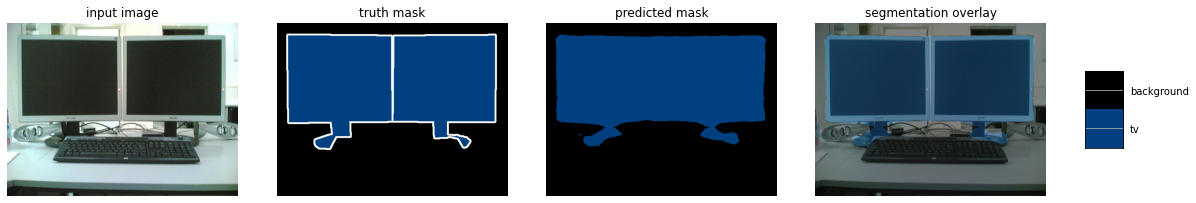

In [ ]:
# Here we check a particular picture
file_name = "2007_000121"
jpg_file_path = os.path.join(FOLDER_IMAGES_JPG, file_name + ".jpg")
png_file_path = os.path.join(FOLDER_IMAGES_PNG_AUG, file_name + ".png")

# Original image
original_image = np.array(Image.open(jpg_file_path))
original_height, original_width, original_depth = original_image.shape
print(f"original_image has shape {original_image.shape}")

# Mask or PNG file
mask_truth = np.array(Image.open(png_file_path))
print(f"mask_truth has shape {mask_truth.shape}")

# Prediction
x = tf.image.decode_jpeg(tf.io.read_file(jpg_file_path))
x = tf.cast(x, "float32")/255.0
x = tf.image.resize(x, (HEIGHT_INPUT, WIDTH_INPUT), method = "bilinear")
x = tf.expand_dims(x, axis = 0)
print(f"x shape is {x.shape}")
mask_predicted_all_classes = deeplabv3.predict(x)
mask_predicted = np.argmax(mask_predicted_all_classes[0,:,:,:], axis=-1)
mask_predicted_3D = tf.stack([mask_predicted, mask_predicted, mask_predicted], axis = -1)
mask_predicted_original_shape = tf.image.resize(mask_predicted_3D, (original_height, original_width), method = "nearest")
mask_predicted_original_shape = mask_predicted_original_shape[:,:,0].numpy()
print(f"mask_predicted_original_shape has shape {mask_predicted_original_shape.shape}")

# Plot now, using the original mask as a predicted segmentation (given that we do not have a prediction yet)
compare_prediction_and_truth(original_image, mask_truth, mask_predicted_original_shape)

Plot n images of a labeled dataset with their mIoU

In [ ]:
def plot_results(dataset_generator, n, model):
    """
    Generates the plots and the mIoU of a given dataset generator

    Arguments:
        - dataset_generator: a generator of the dataset
        - n: number of images to test
        - model: the model to evaluate
    
    Returns
        - None
    """

    for x, y_true in val_image_ds.take(n):
    
        # Take the elements and make the prediction
        y_pred = model.predict(x)
        y_pred = np.argmax(y_pred[0,:,:,:], axis=-1)

        # Compute the metrics
        loss, mIoU, mAcc, pAcc = model.evaluate(x = x, y = tf.expand_dims(y_true, 0), batch_size=1, verbose = 0)

        # Convert to numpy for plotting
        x_numpy = x.numpy()[0]    
        y_true_numpy = y_true.numpy()
        y_pred_numpy = y_pred
        print(f"The mIoU of this prediction is {round(mIoU*100,2)}%")
        compare_prediction_and_truth(x_numpy, y_true_numpy, y_pred_numpy)
        print()

In [ ]:
# Define the validation dataset generator
val_image_ds = get_subset_tf_dataset(
    make_gen_callable(get_subset_filenames_generator("val")), 
    batch_size = 1, 
    epochs = 1, 
    input_size = (HEIGHT_INPUT, WIDTH_INPUT),
    augmentation = False,
    shuffle = False)

plot_results(dataset_generator = val_image_ds, n = 20, model = deeplabv3)

Output hidden; open in https://colab.research.google.com to view.